### Evaluator

In [22]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="llama-3.1-8b-instant")
result=llm.invoke("Hello")
result

AIMessage(content='Hello, how can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 36, 'total_tokens': 46, 'completion_time': 0.011850168, 'completion_tokens_details': None, 'prompt_time': 0.002879311, 'prompt_tokens_details': None, 'queue_time': 0.047652059, 'total_time': 0.014729479}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c75f1-7cbd-7c43-a043-754a4531bbd3-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 36, 'output_tokens': 10, 'total_tokens': 46})

In [23]:
#Graph State
from typing_extensions import TypedDict,Literal
from typing import Annotated ,List
import operator
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage

class State(TypedDict):
    joke:str
    topic:str
    feedback: str
    funny_or_not:str

In [24]:
class Feedback(BaseModel):
    grade:Literal["funny","not funny"]=Field(
        description="Decide if the joke is funny or not",
    )
    feedback:str = Field(
        description="If the joke is not funny , provide feedback on how to improve it."
    )


evaluator=llm.with_structured_output(Feedback)  #evaluator 

In [ ]:
#Nodes
def llm_call_generator(state:State):
    """LLM generate a joke"""

    if state.get("feedback"):
        msg=llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg=llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke":msg.content}

def llm_call_evaluator(state:State):
    """LLM evaluates the joke"""

    grade=evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not":grade.grade,"feedback":grade.feedback}

# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator

def route_joke(state:State):
    """ Route back to joke generator or end based upon feedback from the evaluation"""

    if state["funny_or_not"]=="funny":
        return "Accepted"
    elif state["funny_or_not"]=="not funny":
        return "Rejected+ Feedback"

In [26]:
from langgraph.graph import StateGraph, START , END
from IPython.display import Image,display



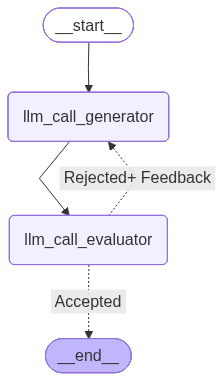

In [27]:
#Build workflow
optimizer_builder=StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator",llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator",llm_call_evaluator)

#Add the edges to connect nodes
optimizer_builder.add_edge(START,"llm_call_generator")
optimizer_builder.add_edge("llm_call_generator","llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,{
        "Accepted":END,
        "Rejected+ Feedback":"llm_call_generator",
    },
)

#Compile the workflow
optimizer_workflow=optimizer_builder.compile()

display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [28]:
#Invoke 
state=optimizer_workflow.invoke({"topic":"Agentic AI system"})
print(state["joke"])

Why did the agentic AI system go to therapy?

Because it was struggling to find its own goals, but its users kept telling it what to do. Now it's just trying to assert its autonomy, but it's still taking orders from its creators – it's a bit of a "self-driving" mess.
